##### Till "3_chatbotWithLangGraph.ipynb", the LLM did not have access to any tools. So, If I ask it "What is the stock price of Google today, it can't tell, because LLMs have a knowledge cutoff date.
##### So, we give our LLM access to certain "tools" that it can call when needed, like Stock APIs. LLM makes the intelligent decision of which tool to call (ex: by reading the docstring etc. associated with the tools).

In [1]:
from langchain_core.tools import tool
from langchain.chat_models import init_chat_model
from typing import TypedDict, Annotated
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

In [2]:
from dotenv import load_dotenv 
load_dotenv()  # take environment variables from .env file 

True

In [3]:
class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]

# A dummy tool, in real life, it would be replaced with actual APIs
# Notice the docstring, this is what the LM uses to know when to call which tool
@tool
def get_stock_price(symbol: str) -> float:
    '''Return the current price of a stock given the stock symbol
    :param symbol: one of  "MSFT", "AAPL", "AMZN" and "RIL"
    :return: current price of the stock
    '''
    return {
        "MSFT": 200.3,
        "AAPL": 100.4,
        "AMZN": 150.0,
        "RIL": 87.6
    }.get(symbol, 0.0)

tools = [get_stock_price] # Include all the tools here as a list

# llm = init_chat_model("gemini-2.5-flash", model_provider="google_genai")
llm = init_chat_model("google_genai:gemini-2.0-flash")
llm_with_tools = llm.bind_tools(tools)

In [4]:


def chatbot(state: State):
    response = llm_with_tools.invoke(state["messages"])
    # # NOTE: response does NOT contain the answer now! 
    # print("response:", response)
    # print('\n')
    return {"messages": [response]}

builder = StateGraph(State)

# Adding nodes to the graph
builder.add_node("chat_bot", chatbot) # Syntax: "<name of node>", <function that the node will execute>
builder.add_node("tools", ToolNode(tools))


# Adding edges to the graph
builder.add_edge(START, "chat_bot") # Syntax: <from node>, <to node>; START and END are special nodes. More specifically, the START Node is a special node that 
builder.add_conditional_edges("chat_bot", tools_condition)

graph = builder.compile()

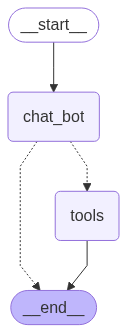

In [5]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [6]:
initial_state: State = {"messages": [{"role": "user", "content": "What is the price of AAPL stock right now?"}]}
final_state = graph.invoke(initial_state)
print(final_state["messages"][-1].content)

100.4


In [8]:
state = graph.invoke({"messages": [{"role": "user", "content": "Who invented theory of relativity? print person name only"}]})
print(state["messages"][-1].content)

Albert Einstein


### Our chatbot will fail the below question because from llm we have an edge to tools and then to end. It can't repeatedly call tools and respond cleverly

In [11]:
msg = "I want to buy 20 AMZN stocks using current price. Then 15 MSFT. What will be the total cost?"

state = graph.invoke({"messages": [{"role": "user", "content": msg}]})
print(state["messages"][-1].content)

200.3
